In [13]:
import cv2
import numpy as np
import pykitti
import os
from pathlib import Path
from matplotlib import pyplot as plt

In [36]:
def extract_features(frame):
    return cv2.goodFeaturesToTrack(frame,256,0.01,10)

In [ ]:
def frame_transform(frames, projection):
    t_0 = frames[0]
    t_1 = frames[1]
    

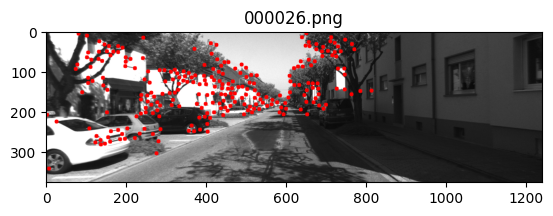

In [37]:
root = Path('sample')
drive = '00'

seq_path = root / 'data_odometry_gray' / 'dataset' / drive / 'image_0'

frames = os.listdir(seq_path)
sorted(frames)

for frame_name in frames:
    frame = cv2.imread(str(seq_path / frame_name), cv2.IMREAD_UNCHANGED)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
#     print(frame.type())
    
    for i in extract_features(frame):
        x,y = i.ravel()
        cv2.circle(frame_rgb,(int(x),int(y)),5,255,-1)
    
    plt.imshow(frame_rgb)
    plt.title(frame_name)
    plt.show()
    break